In [152]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.nn.functional import pad
import seaborn as sns
import warnings

if torch.cuda.is_available():
    DEVICE = torch.device("cuda:1")
else:
    DEVICE = torch.device("cpu")

In [102]:
class LSTMModel_1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel_1, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bias=True,
            dropout=0.0,
        )

        self.fc_1 = nn.Sequential(
            nn.Linear(11, 1),
        )

        self.fc_2 = nn.Sequential(
            nn.Linear(hidden_size // 1, hidden_size // 2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 8, output_size),
        )

        self.fc_b = nn.Linear(input_size - 69, input_size)

    def forward(self, x, x_2023):
        out = self.fc_1(x)
        out = out[..., 0]

        x_2023 = self.fc_b(x_2023)[:, None, ...]
        out = torch.cat([out, x_2023], dim=1)

        out, _ = self.lstm(out)
        out = out[:, -1, ...]
        out = self.fc_2(out)

        return out

In [104]:

class PartialInferenceByCity:
    def __init__(
        self,
        data_root_dir,
    ):
        data_root_dir = Path(data_root_dir)

        if not data_root_dir.is_dir():
            raise ValueError(
                f"The directory {data_root_dir.as_posix()} does not exist."
            )

        self.data_root_dir = data_root_dir

        # read the data

        data_path = data_root_dir / "data.pkl"

        if not data_path.is_file():
            raise ValueError(f"The file {data_path.as_posix()} does not exist.")

        self.data = pd.read_pickle(data_path)

        # calculate price mean and std
        self.price_mean = self.data.Preis.mean()
        self.price_std = self.data.Preis.std()

        # load model
        self.nn = LSTMModel_1(78, 512, 5, 1).to(device=DEVICE).eval()
        self.nn.load_state_dict(torch.load("./final_data/dense_lstm_model.pt"))

        # preprocess the data
        self.__preprocess_data()

        # load distance data
        self.__load_distance_data()

    def __load_distance_data(self):
        self.distance_2018 = pd.read_csv(
            self.data_root_dir / "distances_2018.csv"
        ).set_index("Qid_1")
        self.distance_2019 = pd.read_csv(
            self.data_root_dir / "distances_2019.csv"
        ).set_index("Qid_1")
        self.distance_2020 = pd.read_csv(
            self.data_root_dir / "distances_2020.csv"
        ).set_index("Qid_1")
        self.distance_2021 = pd.read_csv(
            self.data_root_dir / "distances_2021.csv"
        ).set_index("Qid_1")
        self.distance_2022 = pd.read_csv(
            self.data_root_dir / "distances_2022.csv"
        ).set_index("Qid_1")

    def __normalize_columns(self):
        self.cleaned_data.Preis = (
            self.cleaned_data.Preis - self.cleaned_data.Preis.mean()
        ) / self.cleaned_data.Preis.std()
        self.cleaned_data.Laenge = (
            self.cleaned_data.Laenge - self.cleaned_data.Laenge.mean()
        ) / self.cleaned_data.Laenge.std()
        self.cleaned_data.Breite = (
            self.cleaned_data.Breite - self.cleaned_data.Breite.mean()
        ) / self.cleaned_data.Breite.std()
        self.cleaned_data.PPSVACWert = (
            self.cleaned_data.PPSVACWert - self.cleaned_data.PPSVACWert.mean()
        ) / self.cleaned_data.PPSVACWert.std()

        list_of_t = [f"TD{i:02d}" for i in range(1, 35)]

        for i in list_of_t:
            self.cleaned_data[i] = (
                self.cleaned_data[i] - self.cleaned_data[i].mean()
            ) / self.cleaned_data[i].std()

    def __separate_data(self):
        self.data_2018 = (
            self.cleaned_data[self.cleaned_data.GJ == 2018]
            .drop(columns=["Qid", "GJ", "Ort"])
            .copy()
        )
        self.data_2019 = (
            self.cleaned_data[self.cleaned_data.GJ == 2019]
            .drop(columns=["Qid", "GJ", "Ort"])
            .copy()
        )
        self.data_2020 = (
            self.cleaned_data[self.cleaned_data.GJ == 2020]
            .drop(columns=["Qid", "GJ", "Ort"])
            .copy()
        )
        self.data_2021 = (
            self.cleaned_data[self.cleaned_data.GJ == 2021]
            .drop(columns=["Qid", "GJ", "Ort"])
            .copy()
        )
        self.data_2022 = (
            self.cleaned_data[self.cleaned_data.GJ == 2022]
            .drop(columns=["Qid", "GJ", "Ort"])
            .copy()
        )
        self.data_2023 = (
            self.cleaned_data[self.cleaned_data.GJ == 2023]
            .drop(columns=["Qid", "GJ", "Ort"])
            .copy()
        )

    def __preprocess_data(self):
        CONST_COLUMNS = [
            "Stellensubart_1",
            "Stellensubart_2",
            "Stellensubart_3",
            "Stellensubart_4",
            *[f"T{i}" for i in range(1, 35)],
            *[f"TD{i:02d}" for i in range(1, 35)],
            "Preis",
            "Beleuchtet",
            "Laenge",
            "Breite",
            "Eigenfläche",
            "PPSVACWert",
            "Qid",
            "GJ",
            "Ort"
        ]

        # set Qid column as index and take the required columns
        cleaned_data = self.data.set_index("Qid", drop=False)
        cleaned_data.Qid = cleaned_data.Qid.astype(int)
        self.cleaned_data = cleaned_data.loc[:, CONST_COLUMNS]

        # normalize the data
        self.__normalize_columns()

        # separate the data into years
        self.__separate_data()
        
    def __get_city_data(self, city_name):
        if (self.data.Ort == city_name).sum() == 0:
            raise ValueError(f"Unknown city {city_name}")

        MAX_NEIGH = 10

        # columns which will be dropped for target year (2023)
        columns_to_drop = [
            "PPSVACWert",
            *[f"T{i}" for i in range(1, 35)],
            *[f"TD{i:02d}" for i in range(1, 35)],
        ]
        
        city_qids = self.cleaned_data[self.cleaned_data.Ort == city_name].index.values

        all_year_data = [
            self.data_2018,
            self.data_2019,
            self.data_2020,
            self.data_2021,
            self.data_2022,
        ]

        all_year_distances = [
            self.distance_2018,
            self.distance_2019,
            self.distance_2020,
            self.distance_2021,
            self.distance_2022,
        ]
        
        X, x, y = [], [], []
        
        for qid in tqdm(city_qids):
            
            #skip qids that do not have 2023 data
            if (self.data_2023.index == qid).sum() == 0:
                continue
            
            neighbours_features = []

            for year_data, year_distances in zip(all_year_data, all_year_distances):
                
                current_distances = year_distances[year_distances.index == qid]
                                
                #take only those neighbours which are from the same city
                current_distances = current_distances[current_distances.Qid_2.isin(city_qids)]

                if (current_distances.shape[0] != 0) and ((year_data.index == qid).sum() != 0):
                    
                    current_year_neighbours = current_distances[
                        current_distances.Qid_2 != qid
                    ]

                    current_year_neighbours_data = torch.from_numpy(
                        year_data[
                            year_data.index.isin(current_year_neighbours.Qid_2)
                        ].values
                    )
                    current_year_neighbours_data_padded = pad(
                        current_year_neighbours_data,
                        (0, 0, 0, MAX_NEIGH - current_year_neighbours_data.shape[0]),
                        "constant",
                        0,
                    )

                    current_year_self_data = torch.from_numpy(year_data.loc[qid].values)

                    if (current_year_self_data.ndim == 2) and (
                        current_year_self_data.shape[0] > 1
                    ):
                        current_year_self_data = current_year_self_data[0]

                    current_year_data_point = torch.cat(
                        [current_year_self_data[None], current_year_neighbours_data_padded],
                        dim=0,
                    )

                else:
                    current_year_data_point = torch.zeros(11, 78)

                neighbours_features.append(current_year_data_point)

            self_data_2023 = torch.from_numpy(
                self.data_2023.loc[qid].drop(labels=columns_to_drop).values
            )

            neighbours_features = torch.stack(neighbours_features, dim=0)
            label = torch.tensor(self.data_2023.loc[qid, "T1":"T22"].mean())

            X.append(neighbours_features)
            x.append(self_data_2023)
            y.append(label)
            
        return torch.stack(X, dim=0), torch.stack(x, dim=0), torch.stack(y, dim=0)

    
    def __call__(self, city_name):
        
        if not isinstance(city_name, str):
            raise TypeError(f"Expected city_name to be type of str, but got {type(city_name)}.")

        # get data for qid to pass into nn
        city_data = self.__get_city_data(city_name)
        
        X = city_data[0].to(dtype=torch.float32, device=DEVICE).permute(0, 1, 3, 2)
        x = city_data[1].to(dtype=torch.float32, device=DEVICE)
        y_true = city_data[2]
        
        y_pred = self.nn(X, x).detach().cpu()
        
        return y_true, y_pred
        
        

In [124]:
predictor = PartialInferenceByCity(data_root_dir="./final_data/")

In [116]:
large_cities = ["Berlin", "München", "Hamburg", "Köln"]
medium_cities = ["Karlsruhe", "Wiesbaden", "Gelsenkirchen", "Aachen"]
small_cities = ["Kehl", "Geldern", "Papenburg", "Meppen"]

In [123]:
results = {}

for city_name in large_cities:
    results[city_name] =  {"type" : "large"}
    
for city_name in medium_cities:
    results[city_name] =  {"type" : "medium"}

for city_name in small_cities:
    results[city_name] =  {"type" : "small"}

In [125]:
for city_name, value_dict in results.items():
    
    value_dict["y_true"], value_dict["y_pred"] = predictor(city_name)
    

  0%|          | 0/37534 [00:00<?, ?it/s]

  0%|          | 0/20092 [00:00<?, ?it/s]

  0%|          | 0/19495 [00:00<?, ?it/s]

  0%|          | 0/15748 [00:00<?, ?it/s]

  0%|          | 0/2226 [00:00<?, ?it/s]

  0%|          | 0/2661 [00:00<?, ?it/s]

  0%|          | 0/4145 [00:00<?, ?it/s]

  0%|          | 0/2697 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

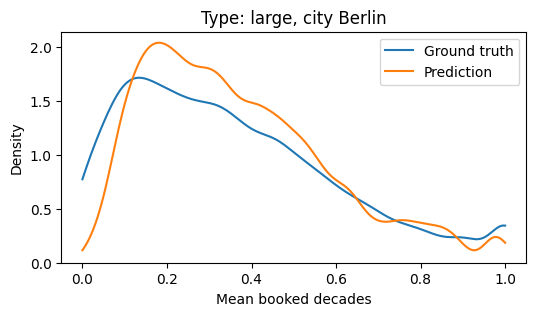

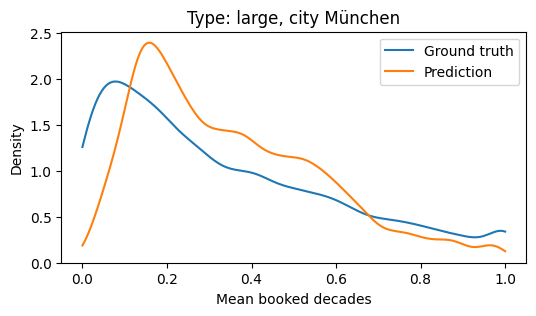

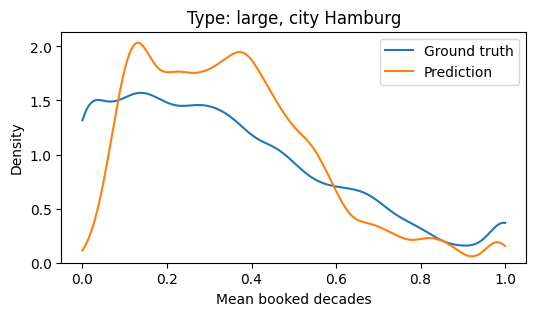

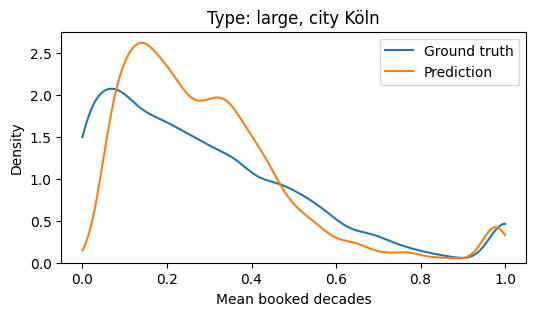

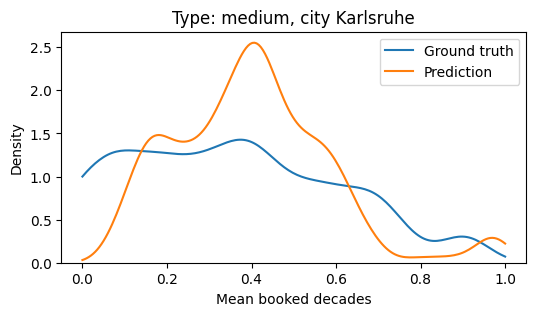

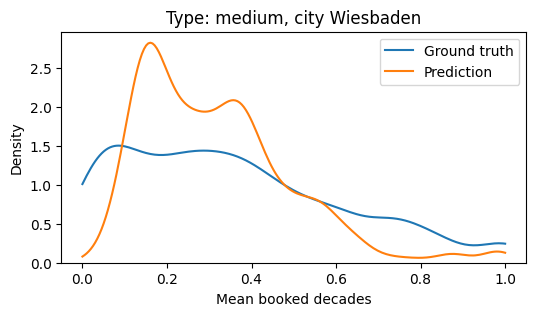

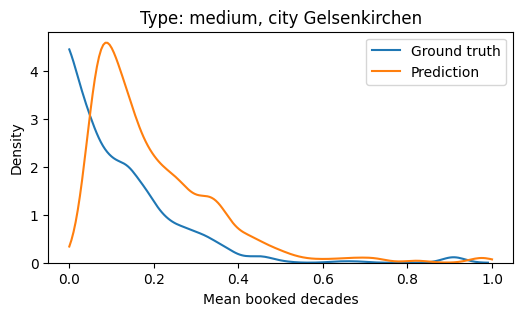

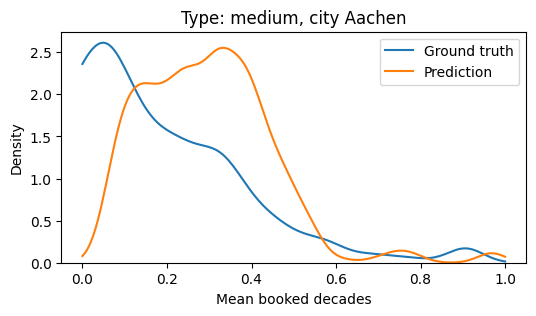

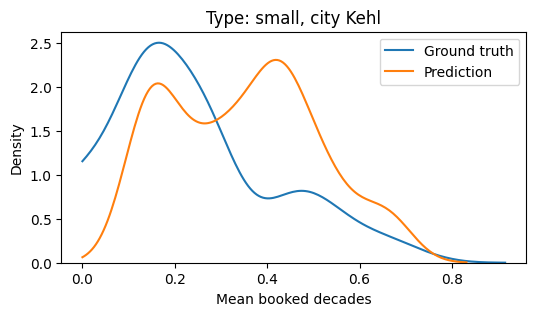

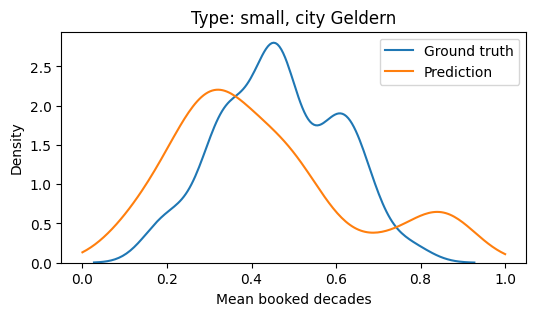

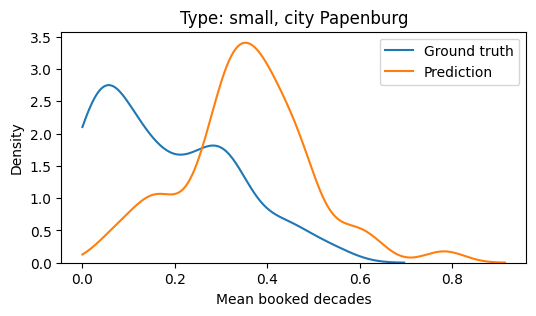

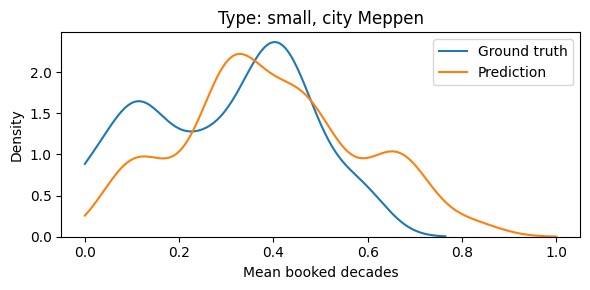

In [159]:
warnings.filterwarnings("ignore")

for idx, (city_name, value) in enumerate(results.items()):
    
    fig, ax = plt.subplots(figsize=(6, 3))
    sns.distplot(value["y_true"],  kde_kws={'clip': (0.0, 1.0)}, hist=False, label='Ground truth', ax=ax)
    sns.distplot(value["y_pred"],  kde_kws={'clip': (0.0, 1.0)}, hist=False, label='Prediction', ax=ax)
    ax.set_xlabel("Mean booked decades")
    ax.legend()
    ax.title.set_text(f"Type: {value['type']}, city {city_name}")
    
fig.tight_layout()